<a href="https://colab.research.google.com/github/Rookiehhh/AI-NoteBooks/blob/main/d2l/me/25-VGG%E5%9D%97%E7%BD%91%E7%BB%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG

In [1]:
# !pip install d2l

In [2]:
import torch
import d2l.torch as d2l
from torch import nn

In [3]:
# 定义VGG块
class VggBlock(nn.Module):

    def __init__(self, conv_nums, in_channels, out_channels):
        super().__init__()
        for i in range(conv_nums):
            self.add_module(f"{2*i+1}", nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.add_module(f"{2*i+2}", nn.ReLU())
            in_channels = out_channels
        self.add_module(f"{conv_nums*2+1}", nn.MaxPool2d(kernel_size=2, stride=2))

    def forward(self, X):
        blk = nn.Sequential(*self._modules.values())
        return blk(X)


In [4]:
VggBlock(10, 10, 20)

VggBlock(
  (1): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU()
  (13): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU()
  (21): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [5]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1#初始输入图像为单通道
    for (num_convs, out_channels) in conv_arch:#依次读取VGG块尺寸并创建
        conv_blks.append(VggBlock(
            num_convs, in_channels, out_channels))
        in_channels = out_channels#输入通道数随每层输出通道数更新

    return nn.Sequential(
        *conv_blks, nn.Flatten(),#“*”将列表中所有元素解开成独立的参数
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(),
        nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(),
        nn.Dropout(0.5), nn.Linear(4096, 10))

In [6]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)
net

Sequential(
  (0): VggBlock(
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): VggBlock(
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): VggBlock(
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): VggBlock(
    (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): VggBloc

In [7]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'ouput shape:\t', X.shape)

VggBlock ouput shape:	 torch.Size([1, 64, 112, 112])
VggBlock ouput shape:	 torch.Size([1, 128, 56, 56])
VggBlock ouput shape:	 torch.Size([1, 256, 28, 28])
VggBlock ouput shape:	 torch.Size([1, 512, 14, 14])
VggBlock ouput shape:	 torch.Size([1, 512, 7, 7])
Flatten ouput shape:	 torch.Size([1, 25088])
Linear ouput shape:	 torch.Size([1, 4096])
ReLU ouput shape:	 torch.Size([1, 4096])
Dropout ouput shape:	 torch.Size([1, 4096])
Linear ouput shape:	 torch.Size([1, 4096])
ReLU ouput shape:	 torch.Size([1, 4096])
Dropout ouput shape:	 torch.Size([1, 4096])
Linear ouput shape:	 torch.Size([1, 10])


In [8]:
#VGG-11计算量太大，这里构建了一个四分之一尺寸的网络来训练,计算量为1/16,但依然很大
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)
print(small_conv_arch)

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]


In [9]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 224)

100%|██████████| 26421880/26421880 [00:07<00:00, 3396376.47it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 172199.94it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3186033.42it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5846812.07it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss 0.184, train acc 0.932, test acc 0.917
794.5 examples/sec on cuda:0


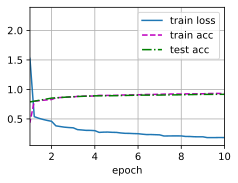

In [10]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())